# **CNN Cancer Detection - Kaggle Mini-Project**

### Step 1- Problem and Data Description

**Problem**

For this Kaggle mini-project, Convolution Neural Network (CNN) will be used to detect cancer in a series of images. The images were taken from digital pathology scans.

**Dataset**

The data source is from [Kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data) The dataset contains two folders of images, with train and test data totaling over 200,000 images. A csv file, train_labels.csv, provides ground truthing with the image name and labels of 0 (no cancer) and 1 (cancer).

### Step 2- Exploratory Data Analysis (EDA)

In [3]:
# Import Packages
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import matplotlib.image as mpimg
import seaborn as sns
from tensorflow.keras import datasets, layers, models, optimizers
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from skimage import io

In [4]:
# Upload Data and Set Directory Paths
train_dir = "train/"
test_dir = "test/"
train = pd.read_csv('train_labels.csv')

In [5]:
# View train labels data
train['id'] = train['id'] + '.tif'
train['label'] = train['label'].astype(str)
train.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7.tif,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da.tif,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f.tif,1
8,559e55a64c9ba828f700e948f6886f4cea919261.tif,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4.tif,0


In [6]:
# View dataframe info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB


In [7]:
# Print count of labels
train = train.copy()
train_count = train['label'].value_counts()
train_count

label
0    130908
1     89117
Name: count, dtype: int64

In [8]:
# Check for duplicates
sum(train.duplicated())

0

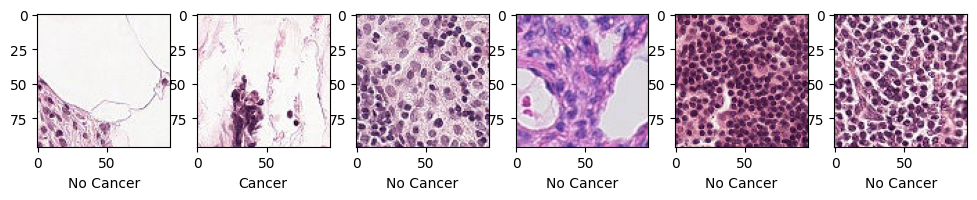

In [9]:
#Image Visualisations
fig, ax = plt.subplots(1, 6, figsize=(12, 12))
for i, axis in enumerate(ax):
    axis.imshow(io.imread(str(train_dir + train.id[i])))
    label = train.label[i]
    if label == '0':
        label = 'No Cancer'
    else:
        label = 'Cancer'
    axis.set(xlabel=label)

Text(0.5, 1.0, 'Cancer Label Counts')

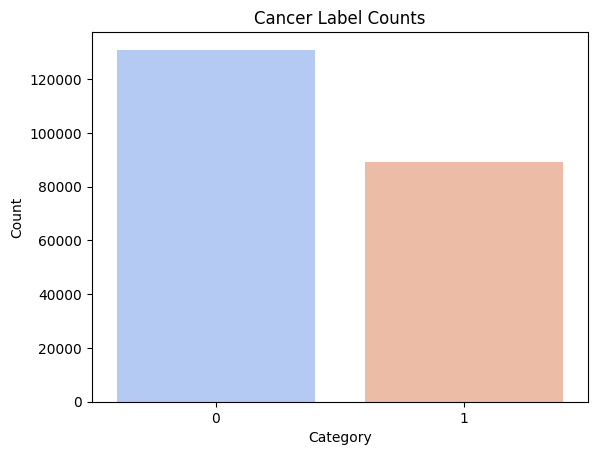

In [10]:
sns.countplot(data=train, x='label', hue='label', palette= "coolwarm")
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Cancer Label Counts')

### Step 3- DModel Architecture
A first CNN model was build using Keras. There are wo identical layers wih pooling and batch normalization. A flatten and dense layer was also built. The model was optimized with Adam optimization.
* Hyperparameter Tuning-
    * The removal of the pooling was positive to the performance and increased the accuracy. It would have been helpful to compare learning rates and some other values. 


##### Model 1



*   **Generator**



In [35]:
dat = ImageDataGenerator(rescale=1/255, validation_split=0.2)
traingen=dat.flow_from_dataframe(dataframe=train, directory=train_dir, subset = 'training', x_col='id', y_col='label',
                                                  shuffle=True, batch_size=32, seed=321)

validgen=dat.flow_from_dataframe(dataframe=train, directory=train_dir, subset = 'validation', x_col='id', y_col='label',
                                                  shuffle=True, batch_size=32, seed=321)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [11]:
# Build CNN Model
cnn = models.Sequential()

cnn.add(layers.Conv2D(filters=32, kernel_size = (3,3), activation='relu', input_shape=(256,256,3)))
cnn.add(layers.Conv2D(filters=32, kernel_size = (3,3), activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))
cnn.add(BatchNormalization())

cnn.add(layers.Conv2D(filters=32, kernel_size = (3,3), activation='relu'))
cnn.add(layers.Conv2D(filters=32, kernel_size = (3,3), activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))
cnn.add(BatchNormalization())

cnn.add(layers.Flatten())
cnn.add(layers.Dense(2, activation='sigmoid'))

cnn.build()
adamopt = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=adamopt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 32)      9

+ **Fit Model 1**

In [37]:
trainedmodel = cnn.fit(traingen, validation_data=validgen, epochs=5)

Epoch 1/5
5501/5501 [==============================] - 794s 144ms/step - loss: 0.5577 - accuracy: 0.7476 - auc: 0.7880 - val_loss: 0.5216 - val_accuracy: 0.7728 - val_auc: 0.8147
Epoch 2/5
5501/5501 [==============================] - 774s 141ms/step - loss: 0.5449 - accuracy: 0.7495 - auc: 0.7926 - val_loss: 0.7923 - val_accuracy: 0.5960 - val_auc: 0.5959
Epoch 3/5
5501/5501 [==============================] - 775s 141ms/step - loss: 0.5398 - accuracy: 0.7535 - auc: 0.7936 - val_loss: 0.5485 - val_accuracy: 0.7100 - val_auc: 0.7845
Epoch 4/5
5501/5501 [==============================] - 840s 153ms/step - loss: 0.5392 - accuracy: 0.7550 - auc: 0.8020 - val_loss: 0.5172 - val_accuracy: 0.7792 - val_auc: 0.8055
Epoch 5/5
5501/5501 [==============================] - 801s 146ms/step - loss: 0.5515 - accuracy: 0.7520 - auc: 0.7859 - val_loss: 0.6366 - val_accuracy: 0.6677 - val_auc: 0.7418


##### Model 2
The second model remove the pooling parameters to see if performance can be improved.

In [28]:
cnn2 = models.Sequential()

cnn2.add(layers.Conv2D(filters=32, kernel_size = (3,3), activation='relu', input_shape=(256,256,3)))
cnn2.add(layers.Conv2D(filters=32, kernel_size = (3,3), activation='relu'))
cnn2.add(BatchNormalization())

cnn2.add(layers.Conv2D(filters=32, kernel_size = (3,3), activation='relu'))
cnn2.add(layers.Conv2D(filters=32, kernel_size = (3,3), activation='relu'))
cnn2.add(BatchNormalization())

cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(2, activation='sigmoid'))

cnn2.build()
adamopt = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn2.compile(optimizer=adamopt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
cnn2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 conv2d_48 (Conv2D)          (None, 252, 252, 32)      9248      
                                                                 
 batch_normalization_23 (Ba  (None, 252, 252, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_49 (Conv2D)          (None, 250, 250, 32)      9248      
                                                                 
 conv2d_50 (Conv2D)          (None, 248, 248, 32)      9248      
                                                                 
 batch_normalization_24 (Ba  (None, 248, 248, 32)      128       
 tchNormalization)                                    

+ **Fit Model 2**

In [29]:
trainedmodel2 = cnn2.fit(traingen, validation_data=validgen, epochs=5)

Epoch 1/5
5501/5501 [==============================] - 1257s 226ms/step - loss: 1.3094 - accuracy: 0.7937 - auc_7: 0.8507 - val_loss: 0.4267 - val_accuracy: 0.8103 - val_auc_7: 0.8870
Epoch 2/5
5501/5501 [==============================] - 1228s 223ms/step - loss: 0.4190 - accuracy: 0.8187 - auc_7: 0.8932 - val_loss: 0.5890 - val_accuracy: 0.7421 - val_auc_7: 0.8422
Epoch 3/5
5501/5501 [==============================] - 1226s 223ms/step - loss: 0.3956 - accuracy: 0.8318 - auc_7: 0.9051 - val_loss: 0.4070 - val_accuracy: 0.8229 - val_auc_7: 0.9020
Epoch 4/5
5501/5501 [==============================] - 1227s 223ms/step - loss: 0.3725 - accuracy: 0.8455 - auc_7: 0.9163 - val_loss: 0.5468 - val_accuracy: 0.7556 - val_auc_7: 0.8222
Epoch 5/5
5501/5501 [==============================] - 1200s 218ms/step - loss: 0.3364 - accuracy: 0.8619 - auc_7: 0.9315 - val_loss: 0.4459 - val_accuracy: 0.8003 - val_auc_7: 0.8795


### Step 4- Results and Analysis
Below are the results for each model and the last one compares the two together.

+ **Model 1 Results** 

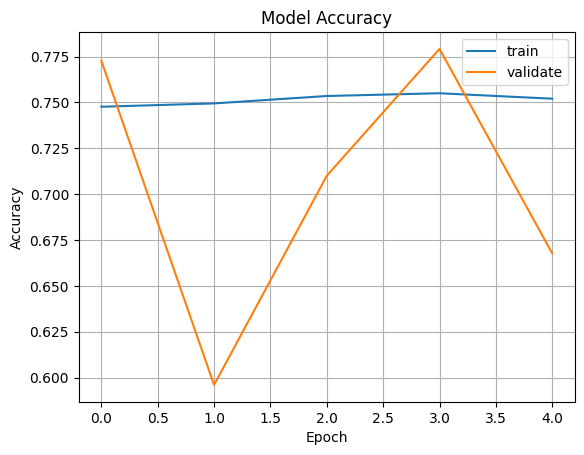

In [49]:
plt.plot(trainedmodel.history['accuracy'], label='train')
plt.plot(trainedmodel.history['val_accuracy'], label='validate')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

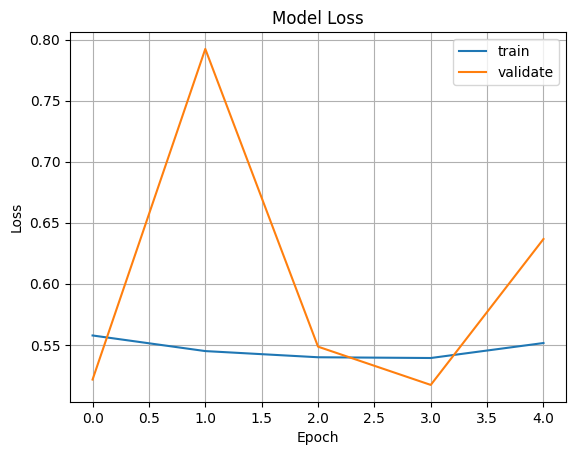

In [48]:
plt.plot(trainedmodel.history['loss'], label='train')
plt.plot(trainedmodel.history['val_loss'], label='validate')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

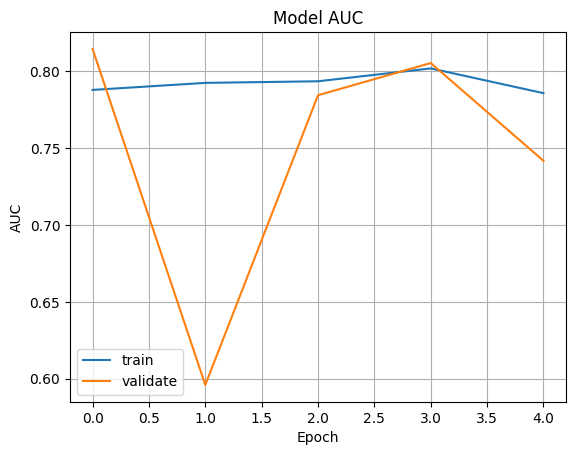

In [47]:
plt.plot(trainedmodel.history['auc'], label='train')
plt.plot(trainedmodel.history['val_auc'], label='validate')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid()
plt.show()

+ **Model 2 Results**

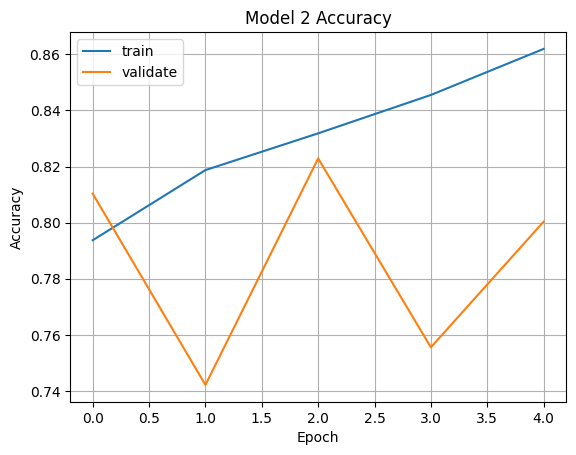

In [46]:
plt.plot(trainedmodel2.history['accuracy'], label='train')
plt.plot(trainedmodel2.history['val_accuracy'], label='validate')
plt.title('Model 2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

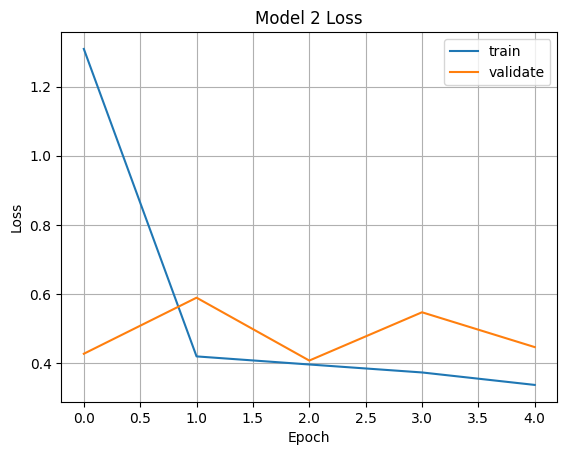

In [45]:
plt.plot(trainedmodel2.history['loss'], label='train')
plt.plot(trainedmodel2.history['val_loss'], label='validate')
plt.title('Model 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

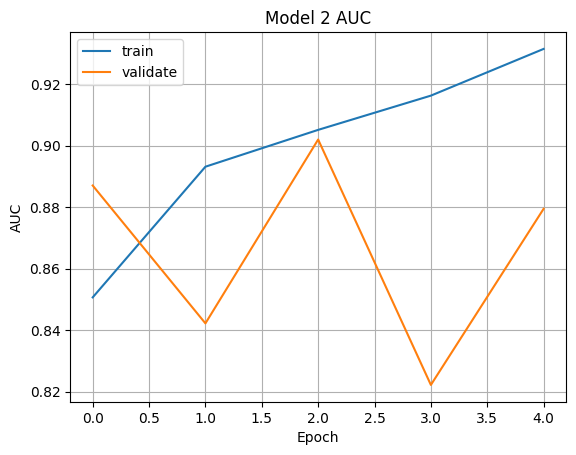

In [44]:
plt.plot(trainedmodel2.history['auc_7'], label='train')
plt.plot(trainedmodel2.history['val_auc_7'], label='validate')
plt.title('Model 2 AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid()
plt.show()

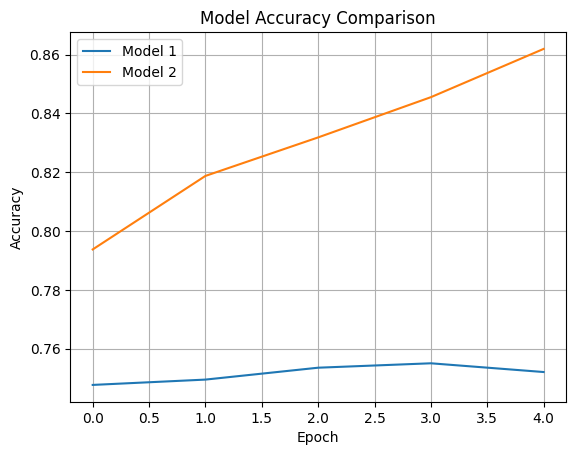

In [50]:
plt.plot(trainedmodel.history['accuracy'], label='Model 1')
plt.plot(trainedmodel2.history['accuracy'], label='Model 2')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

In [56]:
print("Model 1 Accuracy", round(trainedmodel.history['accuracy'][-1],5))
print("Model 2 Accuracy", round(trainedmodel2.history['accuracy'][-1],5))

Model 1 Accuracy 0.75203
Model 2 Accuracy 0.86194


### Step 5- Conclusion
The first model's accuracy of 0.75203 fell much shorted to the 2nd's accuracy of 0.86194. Since the main difference between the two was the max pooling parameter, it appears that max pooling may not have been appropriate for this data set and may have actually slowed down performance. Potential improvements may be to try a different type of pooling, such as max or mixed pooling to see how the results differ. An increase in the number of epochs would have also been helpful, but wasn't implemented due to long lengths of time in fitting the models. 